In [1]:
import os
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

from IPython.display import Image

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
force_cpu = False
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)

Using device cuda


In [4]:
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     root = '/content/drive/MyDrive/Colab Notebooks'
# except:
root = '.'

fig_folder = f"{root}/figures"
backup_folder = f"{root}/backup"

os.listdir(root)
for f in fig_folder, backup_folder:
    os.makedirs(f, exist_ok=True)

print("Backup folder:", backup_folder)
print("Figures folder:", fig_folder)

Backup folder: ./backup
Figures folder: ./figures


In [5]:
batch_size = 64 #  Tutorial: 64
epochs = 15       #  Tutorial : 15

optim_class = torch.optim.RMSprop  #  Tutorial: RMSprop
optim_kwargs = dict(lr=0.001)

In [6]:
train_loader = DataLoader(
    datasets.MNIST(
        'data', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    datasets.MNIST(
        'data', train=False, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=False)

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = nn.Conv2d(1, 32, 3, padding="same")
        self.enc2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.enc3 = nn.Conv2d(64, 64, 3, padding="same")
        self.enc4 = nn.Conv2d(64, 64, 3, padding="same")
        self.enc5 = nn.Linear(12544, 32)

        self.dec1 = nn.Linear(2, 12544)
        self.dec2 = nn.ConvTranspose2d(64, 32, 3, stride=(2, 2), padding=1, output_padding=1)
        self.dec3 = nn.Conv2d(32, 1, 3, padding="same")

        self.mu = nn.Linear(32, 2)
        self.logvar = nn.Linear(32, 2)

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc4(x))
        x = x.flatten(start_dim=1)
        x = F.relu(self.enc5(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):

        z = F.relu(self.dec1(z))
        z = z.view(-1, 64, 14, 14)
        z = F.relu(self.dec2(z))
        x = torch.sigmoid(self.dec3(z))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
# Reconstruction + KL divergence losses summed over all elements and batch
def vae_loss(recon_x, x, mu, logvar):
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    
    return bce + kl

In [9]:
bkp_vae = f"{backup_folder}/vae_alone.p"
force = False

if not os.path.exists(bkp_vae) or force:

    vae = VAE().to(device)
    vae.train()

    optimizer = optim_class(vae.parameters(), **optim_kwargs)

    for epoch in tqdm(range(1, epochs + 1)):

        train_loss = 0
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:

            for batch_idx, (x, _) in enumerate(train_loader):
                x = x.to(device)
                optimizer.zero_grad()
                recon_x, mu, logvar = vae(x)
                loss = vae_loss(recon_x=recon_x, x=x, mu=mu, logvar=logvar)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({"loss": f"{loss.item()/len(x):.4f}"})

        print('====> Epoch: {}\tAverage loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

    torch.save(vae.state_dict(), bkp_vae)
    
else:
    vae = VAE()
    vae.load_state_dict(torch.load(bkp_vae, map_location=device))
    
vae_alone = vae

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.pred1 = nn.Linear(2, 128)
        self.pred2 = nn.Linear(128, 128)
        self.pred3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = F.log_softmax(self.pred3(x), dim=1)
        return x

In [11]:
def classifier_loss(y, pred):
    loss = nn.NLLLoss(reduction='sum')
    return loss(pred, y)

In [12]:
bkp_vae = f"{backup_folder}/vae_and_classifier__vae.p"
bkp_clas = f"{backup_folder}/vae_and_classifier__classifier.p"

force = False

if not os.path.exists(bkp_vae) or not os.path.exists(bkp_clas) or force:

    vae = VAE().to(device)
    classifier = Classifier().to(device)
    vae.train()
    classifier.train()

    optimizer = optim_class(list(vae.parameters()) + list(classifier.parameters()), **optim_kwargs)
    
    weight_clas_loss = 20
    
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:
            
            for batch_idx, (x, y) in enumerate(train_loader):

                x, y = x.to(device), y.to(device)
                
                optimizer.zero_grad()
                
                recon_x, mu, logvar = vae(x)
                l_vae = vae_loss(recon_x=recon_x, x=x, mu=mu, logvar=logvar)
                
                pred = classifier(mu)
                l_class = weight_clas_loss*classifier_loss(y=y, pred=pred)

                loss = l_vae + l_class
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({
                    "loss VAE": f"{l_vae.item()/len(x):.4f}",
                    "loss classifier": f"{l_class.item()/len(x):.4f}"})

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

    torch.save(vae.state_dict(), backup_file_vae)
    torch.save(classifier.state_dict(), backup_file_predictor)
    
else:
    vae = VAE().to(device)
    vae.load_state_dict(torch.load(bkp_vae))
    classifier = Classifier().to(device)
    classifier.load_state_dict(torch.load(bkp_clas))

vae_and_classifier__vae = vae
vae_and_classifier__clas = classifier

In [13]:
def test_vae(model, model_name=""):
    model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            test_loss += vae_loss(recon_x, x, mu, logvar).item()
            if i == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n],
                                      recon_x.view(batch_size, 1, 28, 28)[:n]])
                img_file = f'{fig_folder}/reconstruction_{model_name}.png'
                save_image(comparison.cpu(), img_file, nrow=n)
                display(Image(filename=img_file))

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

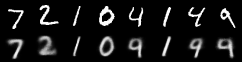

====> Test set loss: 146.1342


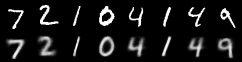

====> Test set loss: 144.3476


In [14]:
test_vae(vae_alone, model_name="vae_alone")
test_vae(vae_and_classifier__vae, model_name="vae_and_classifier")

In [15]:
def nll_plot(predictor):

    def nll_predict(i):
        '''Optimization objective based on predictor output.'''
        return nll_prior - np.log(y_flat[:,i] + 1e-8).reshape(-1, 1)

    def _nll_plot(gx, gy, nll):
        fig = plt.figure(figsize=(15, 6))
        plt.subplots_adjust(hspace=0.4)

        for i in range(10):
            plt.subplot(2, 5, i+1)
            gz = nll(i).reshape(gx.shape)
            im = plt.contourf(gx, gy, gz, 
                              cmap='coolwarm', 
                              norm=LogNorm(), 
                              levels=np.logspace(0.2, 1.8, 100))
            plt.title(f'Target = {i}')
            plt.xlim(-4, 4)
            plt.ylim(-4, 4)

        fig.subplots_adjust(right=0.8)
        fig.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), 
                     ticks=np.logspace(0.2, 1.8, 11), format='%.2f', 
                     label='Negative log likelihood')
    
    rx, ry = np.arange(-4, 4, 0.10), np.arange(-4, 4, 0.10)
    gx, gy = np.meshgrid(rx, ry)

    t_flat = np.c_[gx.ravel(), gy.ravel()]
    t_flat = torch.from_numpy(t_flat).float().to(device)
    with torch.no_grad():
        logp = predictor(t_flat)
    y_flat = logp.exp().cpu().numpy()

    mvn = multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]])
    nll_prior = -mvn.logpdf(t_flat.cpu().numpy()).reshape(-1, 1)

    _nll_plot(gx, gy, nll_predict)

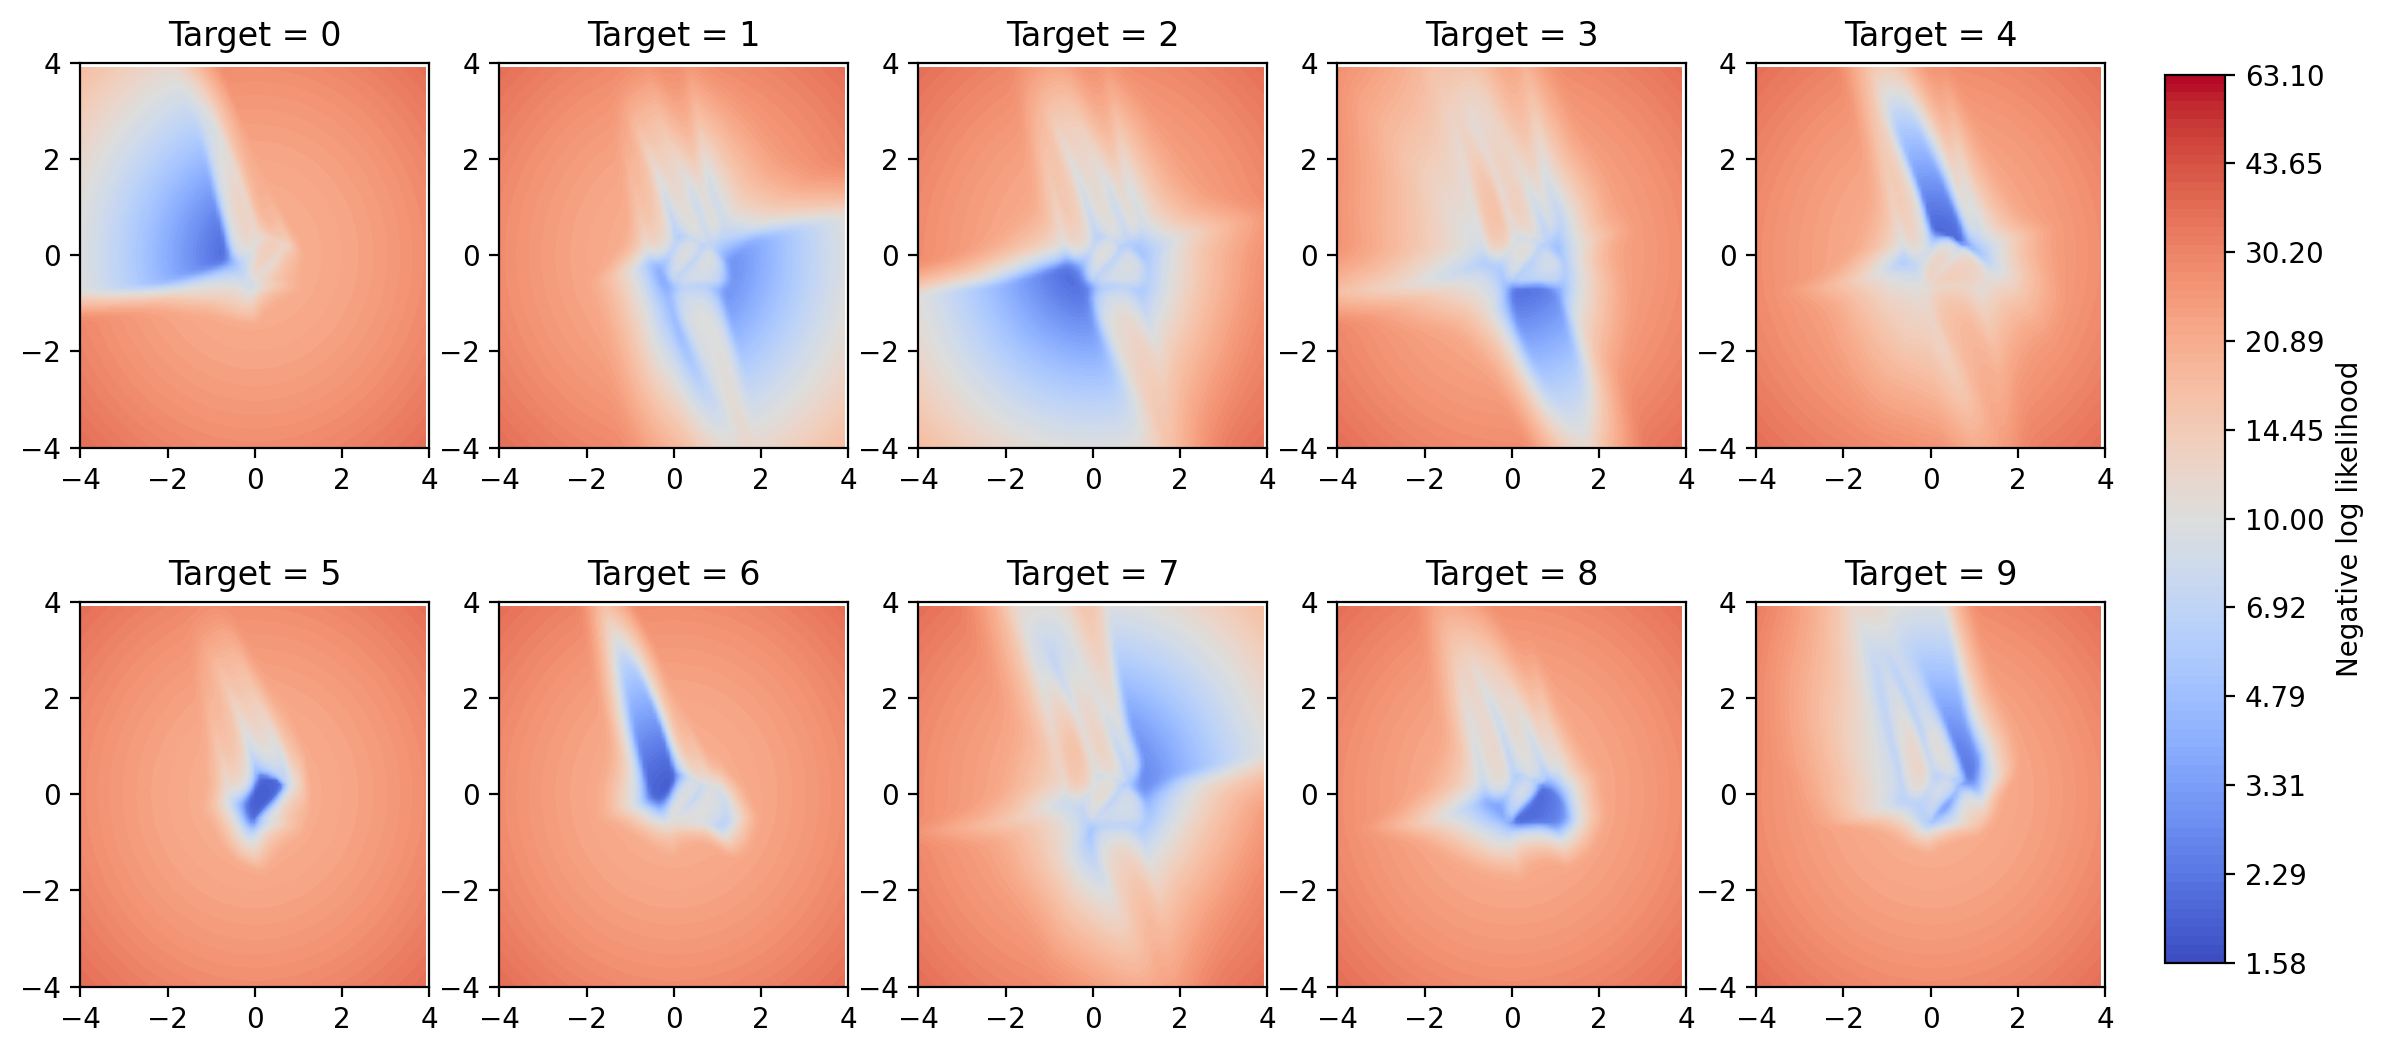

In [16]:
nll_plot(vae_and_classifier__clas)

In [17]:
def plot_latent_space(models):
    
    test_loader = DataLoader(
    datasets.MNIST(
        'data', train=False, transform=transforms.ToTensor()),
        batch_size=5000, shuffle=False)

    x_test = None
    y_test = None
    for _, (x, y) in enumerate(test_loader):
        x_test = x
        y_test = y
        break

    ts = []
    for model in models.values():
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            recon_batch, mu, logvar = model(x_test.to(device))
            ts.append(mu.cpu().numpy())

    if not isinstance(y_test, np.ndarray):
        y_test = y_test.numpy()

    titles = list(models.keys())

    fig, axes = plt.subplots(ncols=len(ts), figsize=(5*len(ts), 4))
    cmap = plt.get_cmap('viridis', 10)

    for i, t in enumerate(ts):
        try:
            ax = axes[i]
        except TypeError:
            ax = axes

        im = ax.scatter(
            t[:, 0], t[:, 1], c=y_test,
            cmap=cmap,
            vmin=-0.5, vmax=9.5,
            marker='o', s=0.4)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
        ax.set_title(titles[i])

    fig.subplots_adjust(right=0.8)
    plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]), ticks=range(10))
    plt.show()

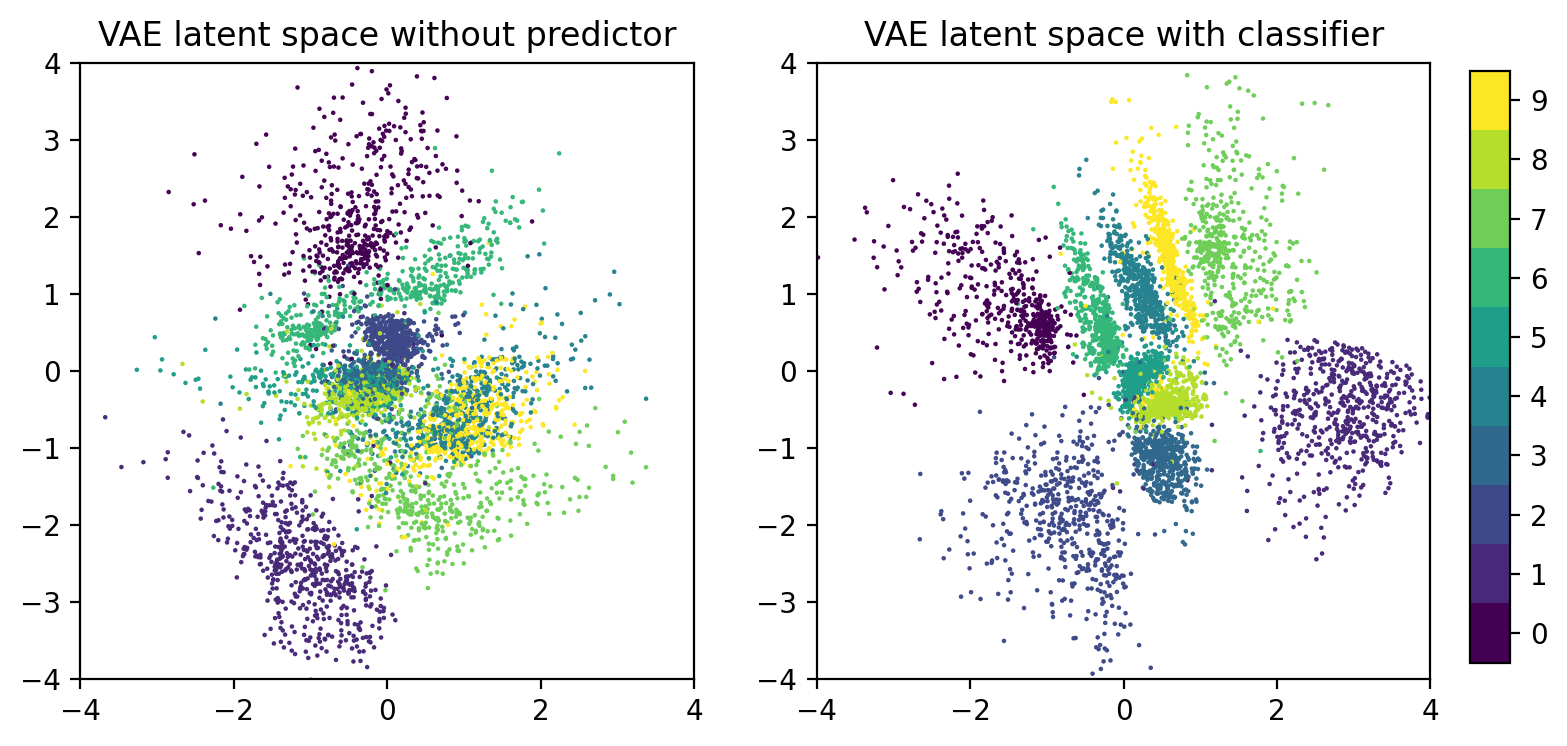

In [18]:
plot_latent_space({
    'VAE latent space without predictor': vae_alone, 
    'VAE latent space with classifier': vae_and_classifier__vae})

In [27]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.pred1 = nn.Linear(2, 128)
        self.pred2 = nn.Linear(128, 128)
        self.pred3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = self.pred3(x)
        return x

In [28]:
def regressor_loss(y, pred):
    loss = nn.MSELoss(reduction="sum")
    output = loss(pred.squeeze(), y.float())
    return output

In [31]:
bkp_vae = f"{backup_folder}/vae_and_regressor__vae.p"
bkp_reg = f"{backup_folder}/vae_and_regressor__regressor.p"

force = False

if not os.path.exists(bkp_vae) or not os.path.exists(bkp_reg) or force:
    
    vae = VAE().to(device)
    reg = Regressor().to(device)
    
    vae.train()
    reg.train()

    optimizer = optim_class(list(vae.parameters())+list(reg.parameters()), **optim_kwargs)
    
    weight_reg_loss = 20

    for epoch in tqdm(range(1, epochs + 1)):
        
        train_loss = 0
        
        with tqdm(total=len(train_loader),
                  position=1, desc=f"Epoch {epoch}") as pbar:
            
            for batch_idx, (x, y) in enumerate(train_loader):

                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                
                recon_x, mu, logvar = vae(x)
                l_vae = vae_loss(recon_x=recon_x, x=x, mu=mu, logvar=logvar)
                
                pred = reg(mu)
                l_reg = weight_reg_loss*regressor_loss(y=y, pred=pred)

                loss = l_vae + l_reg
                
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.update()
                pbar.set_postfix({
                    "loss VAE": f"{l_vae.item()/len(x):.4f}",
                    "loss regressor": f"{l_reg.item()/len(x):.4f}"})

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

    torch.save(vae.state_dict(), bkp_vae)
    torch.save(reg.state_dict(), bkp_reg)
    
else:
    vae = VAE().to(device)
    vae.load_state_dict(torch.load(bkp_vae))
    reg = Regressor().to(device)
    reg.load_state_dict(torch.load(bkp_reg))

vae_and_regressor__vae = vae
vae_and_regressor__reg = reg

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 650850.9135


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 192.9795


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 180.1996


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 4 Average loss: 175.6702


Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 5 Average loss: 170.0414


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 6 Average loss: 165.6048


Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 7 Average loss: 162.2203


Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 8 Average loss: 159.8215


Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 9 Average loss: 157.8508


Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 10 Average loss: 156.1902


Epoch 11:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 11 Average loss: 154.5694


Epoch 12:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 12 Average loss: 153.4619


Epoch 13:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 13 Average loss: 152.2178


Epoch 14:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 14 Average loss: 151.3984


Epoch 15:   0%|          | 0/938 [00:00<?, ?it/s]

====> Epoch: 15 Average loss: 150.4738


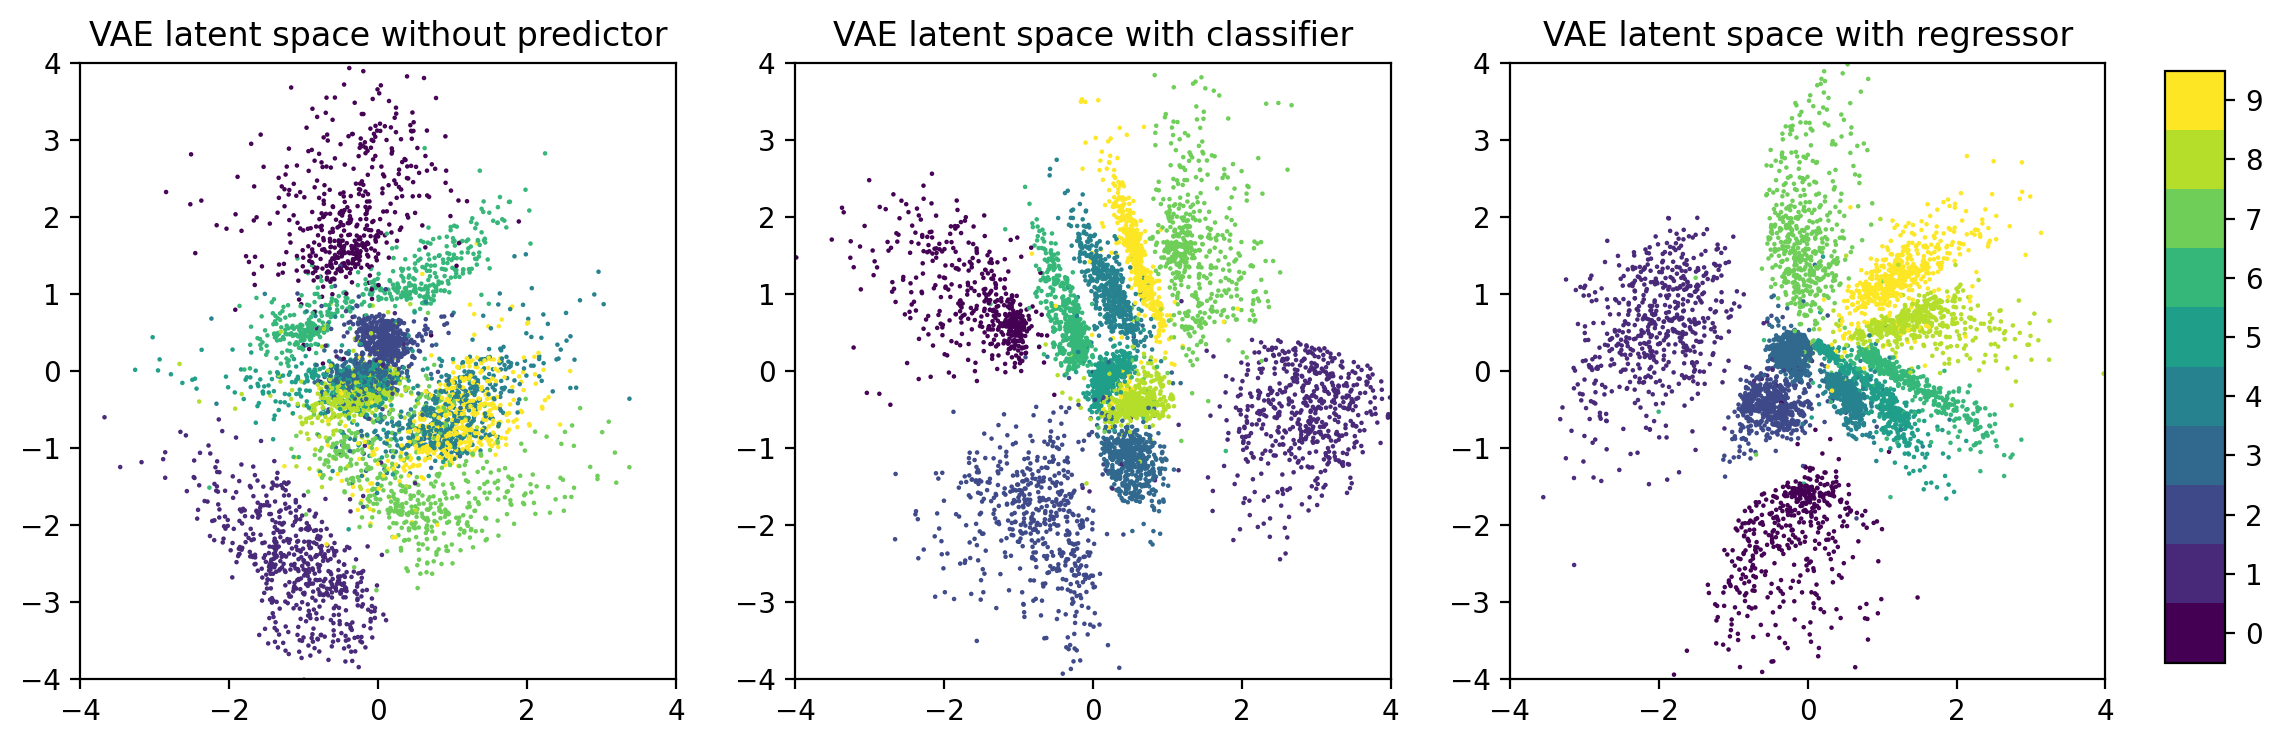

In [32]:
plot_latent_space({
    'VAE latent space without predictor': vae_alone, 
    'VAE latent space with classifier': vae_and_classifier__vae,
    'VAE latent space with regressor': vae_and_regressor__vae})